# 计算全球平均序列

In [2]:
import numpy as np
import pandas as pd
import os
import xarray as xr

from tqdm.notebook import trange

In [2]:
cru_mask = np.load("../../2025_04_Params_Transplant/Data/forcing/cru_mask.npy").astype(np.float32)

gcms_list = ["ACCESS_CM2", "ACCESS_ESM1_5", "CanESM5", "CAS_ESM2_0", "CNRM_CM6_1", "EC_Earth3", "EC_Earth3_Veg_LR", "FGOALS_g3", "FIO_ESM_2_0", "GFDL_ESM4", "GISS_E2_1_G", "GISS_E2_1_H", "INM_CM4_8", "INM_CM5_0", "IPSL_CM6A_LR", "MIROC6", "MPI_ESM1_2_HR", "MPI_ESM1_2_LR", "MRI_ESM2_0", "NorESM2_LM", "NorESM2_MM"]
eles_list = ["pr", "tas", "pet"]
scen_list = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
time_list = {
    "historical": pd.date_range(start="1850-01-01", end="2014-12-31", freq="MS"),
    "ssp126": pd.date_range(start="2015-01-01", end="2099-12-31", freq="MS"),
    "ssp245": pd.date_range(start="2015-01-01", end="2099-12-31", freq="MS"),
    "ssp370": pd.date_range(start="2015-01-01", end="2099-12-31", freq="MS"),
    "ssp585": pd.date_range(start="2015-01-01", end="2099-12-31", freq="MS"),
}

## CRU序列

In [3]:
cru_time_series = pd.date_range(start="1901-01-01", end="2022-12-31", freq="MS")
cru_series_df = pd.DataFrame(index=cru_time_series, columns=eles_list)
cru_series_df.index.name = "Time"
for e in trange(len(eles_list)):
    cru_fp = f"../../2025_04_Params_Transplant/Data/forcing/{eles_list[e]}_cru_1901_2022.npy"
    cru_data = np.load(cru_fp, mmap_mode="r")
    cru_data = cru_data[:].astype(np.float32) * cru_mask[np.newaxis, :, :]
    cru_series_df[eles_list[e]] = np.nanmean(cru_data, axis=(1, 2))
cru_series_df.to_csv("../data/global_mean_series/cru_global_mean_series.txt", sep="\t", index=True, header=True, float_format="%.2f")

  0%|          | 0/3 [00:00<?, ?it/s]

# GLEAM序列

In [7]:
gleam_time_series = pd.date_range(start="1981-01-01", end="2023-12-31", freq="MS")
gleam_series_df = pd.DataFrame(index=gleam_time_series, columns=['AE'])
gleam_series_df.index.name = "Time"

gleam_ds = xr.open_dataset("F:/GLEAM/v42a/E/05/E_GLEAM_merged.nc")
gleam_data = gleam_ds['E'].values

gleam_series_df['AE'] = np.nanmean(gleam_data, axis=(1, 2))
gleam_series_df.to_csv("../data/global_mean_series/gleam/gleam_global_mean_series.txt", sep="\t", index=True, header=True, float_format="%.2f")

In [6]:
gleam_data.shape

(516, 720, 360)

## GCM序列-偏差矫正前气候

In [4]:
for e in trange(2, len(eles_list)):
    ele = eles_list[e]

    for s in trange(len(scen_list)):
        scen = scen_list[s]
        time_series = time_list[scen]

        if scen == "historical":
            stop_num = 1980
        else:
            stop_num = 1020

        gcm_series_df = pd.DataFrame(index=time_series, columns=gcms_list)
        gcm_series_df.index.name = "Time"
        
        for g in trange(len(gcms_list)):
            gcm = gcms_list[g]
            if ele == "pet":
                gcm_fp = f"H:/CMIP6/Processed/DS/{gcm}/1_{ele}_{gcm}_{scen}_pm_050.npy"
            else:
                gcm_fp = f"H:/CMIP6/Processed/DS/{gcm}/1_{ele}_{gcm}_{scen}_DS_cdo_bl_050.npy"

            if not os.path.exists(gcm_fp):
                continue
            try:
                gcm_data = np.load(gcm_fp)
            except:
                continue
            gcm_data = gcm_data[:stop_num].astype(np.float32) * cru_mask[np.newaxis, :, :]
            if ele == "tas":
                gcm_data = gcm_data - 273.15
            gcm_data[np.isinf(gcm_data)] = np.nan
            
            gcm_series_df[gcm] = np.nanmean(gcm_data, axis=(1, 2))
            del gcm_data
        gcm_series_df.to_csv(f"../data/global_mean_series/gcm_ds/{ele}/{ele}_{scen}_global_mean_series.txt", sep="\t", index=True, header=True, float_format="%.2f")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

## GCM序列-偏差矫正后气候

In [5]:
for e in trange(len(eles_list)):
    ele = eles_list[e]

    for s in trange(len(scen_list)):
        scen = scen_list[s]
        time_series = time_list[scen]

        if scen == "historical":
            stop_num = 1980
        else:
            stop_num = 1020

        gcm_series_df = pd.DataFrame(index=time_series, columns=gcms_list)
        gcm_series_df.index.name = "Time"
        
        for g in trange(len(gcms_list)):
            gcm = gcms_list[g]
            gcm_fp = f"H:/CMIP6/Processed/BC/1_{ele}_{gcm}_{scen}_bc_050.npy"

            if not os.path.exists(gcm_fp):
                continue

            gcm_data = np.load(gcm_fp, mmap_mode="r")
            gcm_data = gcm_data[:stop_num].astype(np.float32) * cru_mask[np.newaxis, :, :]
            gcm_data[np.isinf(gcm_data)] = np.nan
            
            gcm_series_df[gcm] = np.nanmean(gcm_data, axis=(1, 2))
        gcm_series_df.to_csv(f"../data/global_mean_series/gcm_bc/{ele}/{ele}_{scen}_global_mean_series.txt", sep="\t", index=True, header=True, float_format="%.2f")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

## GCM序列-模型

In [17]:
gcms_list = ["ACCESS_CM2", "ACCESS_ESM1_5", "CanESM5", "CAS_ESM2_0", "CNRM_CM6_1", "EC_Earth3", "EC_Earth3_Veg_LR", "FGOALS_g3", "FIO_ESM_2_0", "GFDL_ESM4", "GISS_E2_1_G", "GISS_E2_1_H", "INM_CM4_8", "INM_CM5_0", "IPSL_CM6A_LR", "MIROC6", "MPI_ESM1_2_HR", "MPI_ESM1_2_LR", "MRI_ESM2_0", "NorESM2_LM", "NorESM2_MM"]
eles_list = ["natural_runoff", "actural_evaporation", "snow_fall", "soil_moisture", "snow_melt"]
scen_list = ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]
time_list = {
    "historical": pd.date_range(start="1850-01-01", end="2014-12-31", freq="MS"),
    "ssp126": pd.date_range(start="2015-01-01", end="2099-12-31", freq="MS"),
    "ssp245": pd.date_range(start="2015-01-01", end="2099-12-31", freq="MS"),
    "ssp370": pd.date_range(start="2015-01-01", end="2099-12-31", freq="MS"),
    "ssp585": pd.date_range(start="2015-01-01", end="2099-12-31", freq="MS"),
}

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
temp = np.load(f"H:/CMIP6/Processed/FNRD/actural_evaporation/ACCESS_CM2/2_actural_evaporation_ACCESS_CM2_historical_FNRD_050.npy")

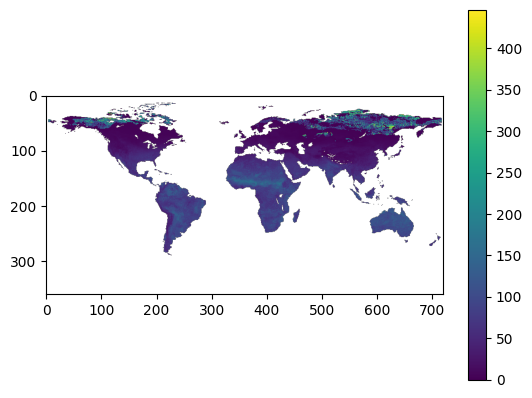

In [14]:
plt.imshow(temp[1])
plt.colorbar()

In [18]:
# for e in trange(len(eles_list)):
for e in trange(1, 2):
    ele = eles_list[e]

    for s in trange(len(scen_list)):
        scen = scen_list[s]
        time_series = time_list[scen]

        if scen == "historical":
            stop_num = 1980
        else:
            stop_num = 1020

        gcm_series_df = pd.DataFrame(index=time_series, columns=gcms_list)
        gcm_series_df.index.name = "Time"
        
        for g in trange(len(gcms_list)):
            gcm = gcms_list[g]
            gcm_fp = f"H:/CMIP6/Processed/FNRD/{ele}/{gcm}/2_{ele}_{gcm}_{scen}_FNRD_050.npy"

            if not os.path.exists(gcm_fp):
                continue

            gcm_data = np.load(gcm_fp, mmap_mode="r")
            gcm_data = gcm_data[:stop_num].astype(np.float32)
            gcm_data[np.isinf(gcm_data)] = np.nan
            gcm_data[0] = gcm_data[1]
            gcm_data = gcm_data * cru_mask[np.newaxis, :, :]
            
            gcm_series_df[gcm] = np.nanmean(gcm_data, axis=(1, 2))
        gcm_series_df.to_csv(f"../data/global_mean_series/FNRD/{ele}/{ele}_{scen}_global_mean_series.txt", sep="\t", index=True, header=True, float_format="%.2f")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]